In [6]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple

import sys
import os
# Get the absolute path to the src directory
src_path = os.path.abspath('..')
if src_path not in sys.path:
    sys.path.append(src_path)

from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solveStateEquation import solveStateEquation, getSourceTerm, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.solveFinDimObjective import solveFinDimProblem
from src.tools import getValueOfFunction, buildIterationFunction
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSemiNewtonStep, computeObjective
from src.proxGradMethod import computeProxGradStep, globalizedSemiSmoothMethod
from dataclasses import dataclass
import osqp
from scipy import sparse
@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.001
    newton_c = 1
    eta = 0.01
    alpha = 0.00001
    beta = 0.000005
    waveSpeed = 1
    gamma = 0.000
    maxNewtonSteps = 200
    randomFactor = 0.05
    yd = []
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

In [7]:

params = Parameters()

active_set = []
new_point = ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params, idx=int(0.2/params.dt))
active_set.append(new_point)
hesseMatrix = HesseMatrix(active_set, params)
weights = np.ones(len(active_set)) * params.alpha
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
#plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt, label='original')
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [u_1, u_2], params)
yd = solveStateEquation(control, params)
params.yd = yd

print('Upper bound objective value:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
params.newton_c = 100
weights = np.ones(len(active_set))
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
active_set = []
new_point = ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params, idx=int(0.2/params.dt))
active_set.append(new_point)
#print('cond: ', np.linalg.cond(hesseMatrix.matrix))
#timeDependentVariableToGif(params.yd, 'output/observation.gif', slowMoFactor=2, T=params.T)
#weights[:] = 0
print('Newton parameter: ', params.newton_c)
#weights_new, slope_new, y_shift_new = globalizedSemiSmoothMethod(weights, slope, y_shift, active_set, hesseMatrix, params)
prob = osqp.OSQP()
P = sparse.csr_matrix(hesseMatrix.matrix)

x = np.concatenate((weights, slope, y_shift))
standard_states = hesseMatrix.standard_states
n = len(active_set) + 2 * params.d
vectorStandardInner = np.zeros((n,))
for idx, func in enumerate(active_set):
    vectorStandardInner[idx] = func.standardInner
for idx, func in enumerate(standard_states):
    vectorStandardInner[len(active_set) + idx] = calculateL2InnerProduct(params.yd, standard_states[idx], params)
additional_ones = np.zeros_like(x)
for idx in range(len(active_set)):
    additional_ones[idx] = 1
q = -vectorStandardInner + additional_ones
l = np.zeros_like(x)
for idx in range(len(active_set), n):
    l[idx] = -np.inf
u = np.ones_like(x) * np.inf
A = sparse.identity(n)
prob.setup(P, q, A, l, u, alpha=1)
res = prob.solve()
print(res)
print(res.x)






Upper bound objective value: 2e-05
Newton parameter:  100
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6, constraints m = 6
          nnz(P) + nnz(A) = 27
settings: linear system solver = qdldl,
[ 9.79760892e-06  9.84872722e-06  5.56577557e-02  1.72957596e-05
 -3.52708430e-03 -5.50635485e-06]
eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.00, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -9.0979e-02   1.53e-21 

In [10]:
print(res.x)
print(res.info.obj_val + 0.5 * calculateL2InnerProduct(params.yd, params.yd, params))

[ 9.79760892e-06  9.84872722e-06  5.56577557e-02  1.72957596e-05
 -3.52708430e-03 -5.50635485e-06]
1.9823168115357115e-05


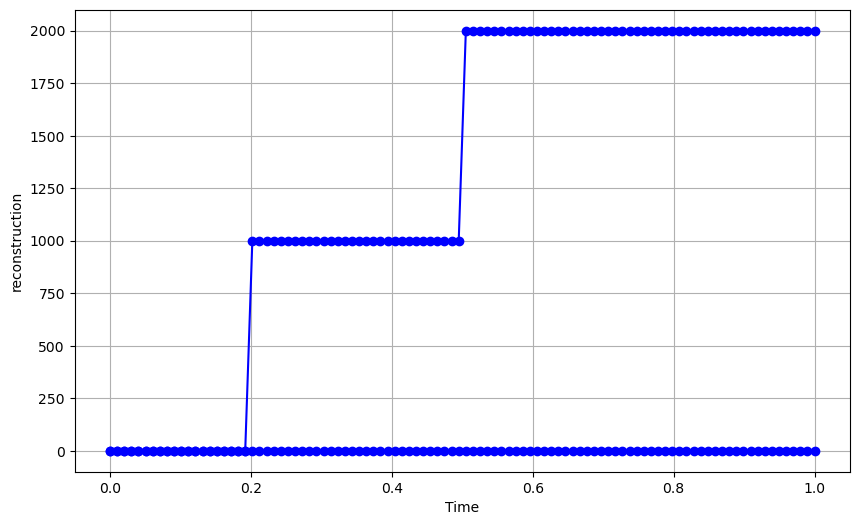

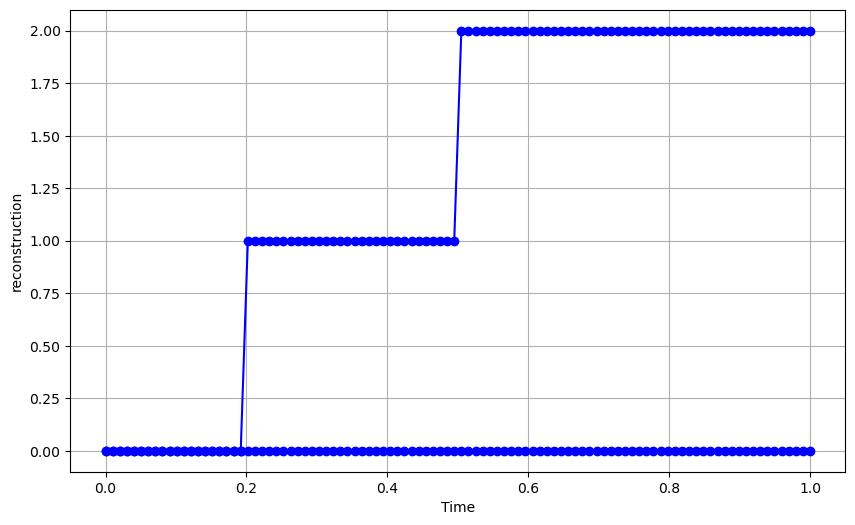

In [3]:
reconstruction_0 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
reconstruction_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]

control = buildControlFunction([g1, g2], [reconstruction_0, reconstruction_1], params)
control_origin = buildControlFunction([g1, g2], [u_1, u_2], params)
state = solveStateEquation(control, params)
#timeDependentVariableToGif(state, 'output/new_state.gif', slowMoFactor=2, T=params.T)
#timeDependentVariableToGif(control, 'output/reconstruction.gif', slowMoFactor=2, T=params.T)
plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt, label='reconstruction')
weights_origin = np.ones(len(active_set)) * params.alpha
slope_origin = np.zeros((params.d,))
y_shift_origin = np.zeros((params.d,))
plot_function(lambda t: buildIterationFunction(t, active_set, weights_origin, slope_origin, y_shift_origin, params), params.T, params.dt, label='reconstruction')
#print(weights / params.alpha)
#print(slope)
#print(y_shift)
#print(active_set[0].x_0)


'''
weight = 2
gamma = 0
phi = [fem.Function(params.V) for _ in params.yd]
hesse = calculateL2InnerProduct(new_point.state, new_point.state, params) + gamma
standard = calculateL2InnerProduct(yd, new_point.state, params)
q = weight + 1/params.newton_c
for k in range(20):
    P_c = max(q - 1/params.newton_c, 0)
    #print(k, ': q:', q)
    #print(k, ': x:', P_c)
    DP_c = 1. if q - 1/params.newton_c >= 0 else 0.
    Df = q * hesse - standard + gamma * q
    G = params.newton_c * (q - P_c) + Df
    DG = params.newton_c * (1 - DP_c) + hesse * DP_c
    #print('DG: ', DG)
    #print('Df')
    dq = -G/DG
    q = q + dq

print('weight:', max(q - 1/params.newton_c, 0))
#plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt)
'''